<a href="https://colab.research.google.com/github/viviaxenov/SHRIMP/blob/main/WIP_ML_potential_with_new_DIFFERENTIABLE_descriptors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Imports & Utils

In [ ]:
!pip install -q git+https://www.github.com/deepmind/haiku
!pip install -q --upgrade git+https://www.github.com/google/jax-md

# Imports

import os
import numpy as onp
import pickle

import jax
from jax import lax

from jax.api import jit, vmap, grad

# TODO: Re-enable x64 mode after XLA bug fix.
# from jax.config import config ; config.update('jax_enable_x64', True)
import warnings
warnings.simplefilter('ignore')
import jax.numpy as np


from jax import random

from jax_md import energy, space, simulate, quantity

# Plotting.

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl
from IPython import display
from functools import partial
  
sns.set_style(style='white')
sns.set(font_scale=1.6)

def format_plot(x, y):
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_facecolor('white')
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def draw_training(params):
  display.clear_output(wait=True)
  display.display(plt.gcf())
  plt.subplot(1, 2, 1)
  plt.semilogy(train_energy_error)
  plt.semilogy(test_energy_error)
  plt.xlim([0, train_epochs])
  format_plot('Epoch', '$L$')
  plt.subplot(1, 2, 2)
  predicted = vectorized_energy_fn(params, example_positions)
  plt.plot(example_energies, predicted, 'o')
  plt.plot(np.linspace(-400, -300, 10), np.linspace(-400, -300, 10), '--')
  format_plot('$E_{label}$', '$E_{prediction}$')
  finalize_plot((2, 1))
  plt.show()

# Data Loading.

def MD_trajectory_reader(f, no_skip=20):
  filename = os.path.join('Supplementary/', f)
  fo = open(filename, 'r')
  samples = fo.read().split('iter= ')[1:]
  steps = []
  lattice_vectors = []
  positions = []
  forces = []
  temperatures = []
  energies = []
  for sample in samples[::no_skip]:
    entries = sample.split('\n')
    steps.append(int(entries[0]))
    lattice_vectors.append(onp.array([list(map(float, lv.split())) for lv in entries[1:4]]))
    assert entries[4]=='64'
    temp = onp.array([list(map(float, lv.split()[1:])) for lv in entries[5:69]])
    positions.append(temp[:,:3])
    forces.append(temp[:,3:])
    remaining_lines = entries[69:]
    temperatures.append(float([entry for entry in entries[69:] if 'Temp' in entry ][0].split('=')[1].split()[0]))
    energies.append(float([entry for entry in entries[69:] if 'el-ion E' in entry ][0].split('=')[1].split()[0]))
  assert (len(set(steps))-(steps[-1]-steps[0]+1)/no_skip) < 1
  return np.array(positions), np.array(energies), np.array(forces)

def build_dataset():
  no_skip = 15
  data300, energies300, forces300 = MD_trajectory_reader(
      'MD_DATA.cubic_300K', no_skip=no_skip)
  data600, energies600, forces600 = MD_trajectory_reader(
      'MD_DATA.cubic_600K', no_skip=no_skip)
  data900, energies900, forces900 = MD_trajectory_reader(
      'MD_DATA.cubic_900K', no_skip=no_skip)
  dataliq, energiesliq, forcesliq = MD_trajectory_reader(
      'MD_DATA.liq_1', no_skip=no_skip)

  all_data = np.vstack((data300, data600, data900))
  all_energies = np.hstack((energies300, energies600, energies900))
  all_forces = np.vstack((forces300, forces600, forces900))
  noTotal = all_data.shape[0]

  onp.random.seed(0)
  II = onp.random.permutation(range(noTotal))
  all_data = all_data[II]
  all_energies = all_energies[II]
  all_forces = all_forces[II]
  noTr = int(noTotal * 0.65)
  noTe = noTotal - noTr
  train_data = all_data[:noTr]
  test_data = all_data[noTr:]

  train_energies = all_energies[:noTr]
  test_energies = all_energies[noTr:]

  train_forces = all_forces[:noTr]
  test_forces = all_forces[noTr:]

  return ((train_data, train_energies, train_forces),
          (test_data, test_energies, test_forces))

In [ ]:
!pip install -q git+https://www.github.com/google/jax-md

In [ ]:
import time 

from functools import partial
import numpy as onp

import jax.numpy as np

from jax.api import jit
from jax.api import grad
from jax.api import vmap
from jax.api import value_and_grad

from jax import random
from jax import lax

from jax.experimental import stax
from jax.experimental import optimizers

from jax.config import config
config.update('jax_enable_x64', True)

from jax_md import space
from jax_md import minimize
from jax_md import simulate
from jax_md import space
from jax_md import energy
from jax_md import quantity

In [ ]:
# NOTE(schsam): We need this in OSS I think.
from IPython.display import HTML, display
import time

def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')
sns.set(font_scale=1.6)

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

In [ ]:
f32 = np.float32
f64 = np.float64

In [ ]:
def box_size_at_number_density(particle_count, number_density):
  return f32((particle_count / number_density) ** 0.5)

In [ ]:
def pair_correlation_fun(dist_fun, cutoff=2.0, bin_count=60, sigma=None):
  """Calculates the pair correlation function for a collection of atoms."""
  if sigma is None:
    sigma = cutoff / bin_count
  bins = np.linspace(0.1, cutoff, bin_count)

  dist_fun = vmap(vmap(dist_fun, (0, None)), (None, 0))

  def compute(R):
    # TODO(cubuk): Change this function to do batched calculation, as it can
    # require too much memory for more than 1000 particles.
    dr = dist_fun(R, R)
    dr = np.where(dr > 1e-7, dr, 1e7)
    dim = R.shape[1]
    exp = np.exp(-0.5 * (dr[:, :, np.newaxis] - bins) ** 2 / sigma ** 2)
    gaussian_distances = exp / np.sqrt(2 * np.pi * sigma ** 2)
    return np.mean(gaussian_distances, axis=1) / bins ** (dim - 1)
  return compute

# Dataset download and preliminaries

In [ ]:
#@title Download Data

!wget https://aip.scitation.org/doi/suppl/10.1063/1.4990503/suppl_file/supplementary.zip
!wget https://github.com/google/jax-md/blob/master/examples/models/si_gnn.pickle?raw=true
!unzip supplementary.zip

--2021-03-19 14:33:29--  https://aip.scitation.org/doi/suppl/10.1063/1.4990503/suppl_file/supplementary.zip
Resolving aip.scitation.org (aip.scitation.org)... 104.17.164.62, 104.17.163.62
Connecting to aip.scitation.org (aip.scitation.org)|104.17.164.62|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://aip.scitation.org/doi/suppl/10.1063/1.4990503/suppl_file/supplementary.zip?cookieSet=1 [following]
--2021-03-19 14:33:30--  https://aip.scitation.org/doi/suppl/10.1063/1.4990503/suppl_file/supplementary.zip?cookieSet=1
Reusing existing connection to aip.scitation.org:443.
HTTP request sent, awaiting response... 302 Found
Location: https://aip.scitation.org/doi/suppl/10.1063/1.4990503/suppl_file/supplementary.zip [following]
--2021-03-19 14:33:30--  https://aip.scitation.org/doi/suppl/10.1063/1.4990503/suppl_file/supplementary.zip
Reusing existing connection to aip.scitation.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 303986059 (290

In [ ]:
train, test = build_dataset()

train_positions, train_energies, train_forces = train
test_positions, test_energies, test_forces = test

energy_mean = np.mean(train_energies)
energy_std = np.std(train_energies)

print('positions.shape = {}'.format(train_positions.shape))
print('<E> = {}'.format(energy_mean))

positions.shape = (2416, 64, 3)
<E> = -368.9131436758775


# Machine Learned Potentials

## New descriptors

In [ ]:
import jax
import jax.numpy as np

import numpy as onp
import numpy.polynomial as P

from functools import partial

def get_assoc_legendre_coefs(l_max=10):
  max_deg = P.legendre.leg2poly(onp.array([0]*(l_max)+[1.])).shape[0]
  coefs = onp.zeros((l_max + 1, l_max + 1, max_deg))

  for l in range(l_max + 1):
    l_poly = P.Legendre(onp.array([0.]*(l)+[1.]))
    for m in range(l + 1):
      lm_poly = l_poly.deriv(m)
      x_basis_coefs = P.legendre.leg2poly(lm_poly.coef)
      deg = x_basis_coefs.shape[0]
      coefs[l, m, :deg] = x_basis_coefs[::]

  return coefs[:, :, ::-1]


def get_normalization_coefs(l_max=10):
  coefs = onp.zeros((l_max + 1, l_max + 1))
  for l in range(l_max + 1):
    for m in range(l + 1):
      prod = onp.arange(l - m + 1, l + m + 1).prod()
      coefs[l, m] = (-1)**m*onp.sqrt((2*l + 1)/4./onp.pi/prod)

  return coefs


def cartesian_to_spheric(x: np.array):
  """
    Translates cartesian coords to spheric
    Args:
      x - [[x_1, x_2, x_3], ] array of coordinates
  """
  x = np.atleast_2d(x)

  r = np.linalg.norm(x, axis=1)
  theta = np.arccos(x[:, 2]/r)
  phi = np.arctan2(x[:, 1], x[:, 0])

  return r, theta, phi


def get_feature_evaluation_function(k_max=10, l_max=10, R=1.0, radial_comp_type='fourier'):
  
  # TODO: implement different types
  if radial_comp_type != 'fourier':
    raise NotImplementedError("Only fourier radial basis availiable at the moment")

  #ks = np.arange(-k_max, k_max + 1)
  ls = np.arange(l_max + 1)
  ms = np.arange(-l_max, l_max + 1)
  ks = np.arange(-k_max, k_max +1)

  def radial_comp_fourier(k, r):
    arg = 2*np.pi*np.abs(k)*r/R
    trig = np.where(k >= 0, np.cos(arg), np.sin(arg))
    res = trig/np.sqrt(R)/r
    return np.where(r < R, res, 0.)


  def sph_harm(m, l, phi, theta):
    am = np.abs(m)
    t = np.cos(theta)
    p_lm = np.polyval(legendre_coefs[l, am, :], t)*(1 - t**2)**(am/2.)
    trig = jax.lax.cond(m >= 0, np.cos, np.sin, am*phi)
    return p_lm*normalization_coefs[l, am]*trig

  sph_harm = np.vectorize(sph_harm)


  evaluate_radial_comp = radial_comp_fourier # TODO (?) implement different types

  # we evaluate all the coefs that will be used in computations on the CPU
  # then load them to GPU
  legendre_coefs = np.array(get_assoc_legendre_coefs(l_max))
  normalization_coefs = np.array(get_normalization_coefs(l_max))
  @jax.jit
  def evaluate_decomposition_coefs(x):
    r, theta, phi = cartesian_to_spheric(x)

    rr, kk = np.meshgrid(r, ks, indexing='ij')
    rad_comp = evaluate_radial_comp(kk, rr)

    pphi, ll, mm = np.meshgrid(phi, ls, ms, indexing='ij')
    ttheta = np.broadcast_to(theta, pphi.T.shape).T

    ang_comp = sph_harm(mm, ll, pphi, ttheta)
    
    return np.tensordot(rad_comp, ang_comp, axes=([0], [0]))

  @jax.jit
  def evaluate_ri_descriptors(x):
    C = evaluate_decomposition_coefs(x)
    return np.linalg.norm(C, axis=2, ord=2)

  return evaluate_ri_descriptors, (2*k_max + 1, l_max + 1)


In [ ]:
from jax_md import partition

# R is a hyperparameter defining the radius of interaction
# is taken similar to baseline JAX-MD notebook

R = 3.0
box_size = 10.862  # The size of the simulation region (as in JAX-MD notebook)
displacement, shift = space.periodic(box_size)

displacement_from_particle = jax.jit(jax.vmap(displacement, in_axes=(0, None)))

neighbor_list_fn = partition.neighbor_list(displacement, box_size=box_size, r_cutoff=R, dr_threshold=0.0)
_neighbor_lists = neighbor_list_fn(train_positions[0, :, :])

evaluate_features, features_shape = get_feature_evaluation_function(k_max=10, l_max=10, R=R)

evaluate_features = jax.jit(evaluate_features)

N_ri_features = features_shape[0]*features_shape[1]


no_hidden_units = 30
init_fun, _E = stax.serial(
    stax.Dense(no_hidden_units), stax.Relu, # hidden layer 1
    stax.Dense(no_hidden_units), stax.Relu, # hidden layer 2
    stax.Dense(no_hidden_units), stax.Relu, # hidden layer 3
    stax.Dense(1))  # readout  
E_p = lambda params, features: _E(params, features)


@jax.jit
def evaluate_config_energy(params, conf_positions: np.array):  
  N_particles, dim = conf_positions.shape
  neighbor_lists = neighbor_list_fn(conf_positions, _neighbor_lists)
  # TODO eradicate python cycle somehow

  E_config = 0.
  
  for p in range(N_particles):
    neighbor_idx = neighbor_lists.idx[p, :]
    x = displacement_from_particle(conf_positions[neighbor_idx, :], conf_positions[p, :])

    neighbor_idx = np.broadcast_to(neighbor_idx, (3, neighbor_idx.shape[0])).T
    x = np.where(neighbor_idx == N_particles, R, x)

    f = evaluate_features(x, ).ravel()

    E_config += E_p(params, f.ravel())[0]

  return E_config

energy_grad = jax.grad(evaluate_config_energy, argnums=1)
force_fn =  lambda params, conf_pos, **kwargs: -energy_grad(params, conf_pos)

vectorized_energy = jax.jit(jax.vmap(evaluate_config_energy, in_axes=(None, 0)))
vectorized_force = jax.jit(jax.vmap(force_fn, in_axes=(None, 0)))

### Defining the NN architecture

In [ ]:
key = jax.random.PRNGKey(42)
key, net_key = random.split(key)
_, params = init_fun(net_key, (-1,  -1, N_ri_features))


In [ ]:
@jax.jit
def loss(params, positions, E_ref, Fs_ref):
  E_pred = vectorized_energy(params, positions)
  E_rmse = np.mean((E_pred - E_ref)**2)

  
  Fs_pred = vectorized_force(params, positions)
  Fs_rmse = np.mean(((Fs_pred - Fs_ref)**2).sum(axis=(1,2)))

  regularizer = 0 # TODO invent a regularizer
  return E_rmse + Fs_rmse + regularizer
grad_loss = jax.jit(grad(loss, argnums=0))

To train our neural network, we will use JAX's optimizers. As with our simulation functions, optimizers return a triple e.g. `(opt_init, opt_update, get_params) = optimizers.adam(step_size)`. Here `state = opt_init(params)` initializes the optimizers state, `state = opt_update(step, dparams, state)` updates the state of the optimizer using gradients, and `params = opt_params(state)` gets parameters from an optimizer state.

### Defining the training loop

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
basedir = '/content/drive/MyDrive/Colab Notebooks/ml_md_output'

In [ ]:
train_steps = 1001
print_every = 200
batch_size = 50

no_training_samples = train_positions.shape[0]

training_samples = np.arange(no_training_samples)


# Initialize the network.
key = jax.random.PRNGKey(42)
key, net_key = random.split(key)
_, params = init_fun(net_key, (-1,  -1, N_ri_features))

# Create the optimizer.
# 30k steps, 28 mev/atom
#opt_init, opt_update, get_params = optimizers.adam(1e-3)

lr_schedule = optimizers.make_schedule(lambda k: 1e-4/np.sqrt(k + 1000))
#lr_schedule = optimizers.make_schedule(5e-6)
opt_init, opt_update, get_params = optimizers.nesterov(lr_schedule, .1)
state = opt_init(params)

# Define and jit a single update step.
@jit
def update_step(state, batch, i):
  positions, E_ref, Fs_ref = batch
  params = get_params(state)
  d_params = grad_loss(params, positions, E_ref, Fs_ref)
  return opt_update(i, d_params, state)


def batch(key):
  steps_per_epoch = no_training_samples // batch_size 
  train_epochs = train_steps // steps_per_epoch
  print(f'# of epochs: {train_epochs}')
  for s in range(train_epochs):
    key, split = random.split(key)
    permutation = random.shuffle(split, training_samples)
    for i in range(0, no_training_samples, batch_size):
      batch_data = (train_positions[permutation[i:i + batch_size], :, :],
                    train_energies[permutation[i:i + batch_size]],
                    train_forces[permutation[i:i + batch_size], :, :]
                    )
      yield batch_data
  

best_params = get_params(state)
min_loss = loss(best_params, train_positions, train_energies, train_forces)
train_losses = []
test_losses = []
opt_init, opt_update, get_params = optimizers.adam(1e-3)
state = opt_init(params)
  

In [ ]:
train_steps = 600001


# Do the training.
t = time.time()

for i, b in ProgressIter(enumerate(batch(key)), train_steps):
  state = update_step(state, b, i)
  
  # Print some diagnostics.
  if i and i % print_every == 0:
    dt = time.time() - t

    cur_params = get_params(state)

    train_loss = loss(cur_params, train_positions, train_energies, train_forces)
    train_losses += [train_loss]
    
    test_loss = loss(cur_params, test_positions, test_energies, test_forces)
    test_losses += [test_loss]

    if train_loss < min_loss:  
      min_loss = train_loss
      best_params = cur_params

    print(('Time: {:5.2f}\tStep: {:4d}\t'
           'Training-loss: {:5.4f}\tTest-loss: {:5.4f}').format(
         dt, i, train_loss, test_loss))
    t = time.time()
    with open('losses.pkl', 'wb') as ofile:
      pickle.dump({'train': train_losses, 'test': test_losses}, ofile)

    try:
      os.remove(os.path.join(basedir, 'weights.npz'), )
    except FileNotFoundError:
      pass
    np.save(os.path.join(basedir, 'weights.npz'), best_params, )
    with open(os.path.join(basedir, 'losses.pkl'), 'wb') as ofile:
      pickle.dump({'train': train_losses, 'test': test_losses}, ofile)


# of epochs: 12500
Time: 25.70	Step:  200	Training-loss: 358.0490	Test-loss: 356.7678
Time: 25.59	Step:  400	Training-loss: 234.2233	Test-loss: 233.4861
Time: 25.57	Step:  600	Training-loss: 166.0791	Test-loss: 165.8109
Time: 25.56	Step:  800	Training-loss: 130.6592	Test-loss: 130.6222
Time: 25.56	Step: 1000	Training-loss: 108.0339	Test-loss: 108.2891
Time: 25.54	Step: 1200	Training-loss: 93.6906	Test-loss: 94.7480
Time: 25.55	Step: 1400	Training-loss: 83.4794	Test-loss: 84.4741
Time: 25.54	Step: 1600	Training-loss: 76.6676	Test-loss: 77.3729
Time: 25.54	Step: 1800	Training-loss: 71.5121	Test-loss: 71.7311
Time: 25.53	Step: 2000	Training-loss: 64.8970	Test-loss: 65.6805
Time: 25.54	Step: 2200	Training-loss: 60.6273	Test-loss: 60.7539
Time: 25.49	Step: 2400	Training-loss: 57.4105	Test-loss: 57.7579
Time: 25.54	Step: 2600	Training-loss: 56.0557	Test-loss: 55.8751
Time: 25.53	Step: 2800	Training-loss: 48.3600	Test-loss: 48.7014
Time: 25.53	Step: 3000	Training-loss: 44.0282	Test-loss: 44.1

Now that we've trained the network, we can define a neural network energy that we can use in simulations using a single line. 


In [ ]:
neural_energy_fun = lambda positions: vectorized_energy(best_params, positions)

We can plot the losses during training as well as the predicted energies against the ground truth energies on the test set.

### Preliminary results

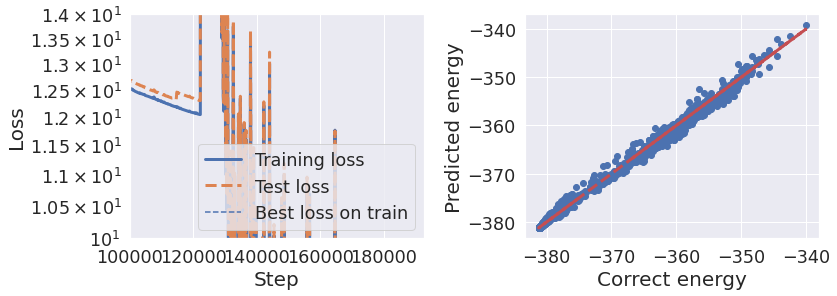

In [ ]:
plt.subplot(1, 2, 1)

out_steps = [x * print_every for x in range(len(train_losses))]
plt.plot(out_steps[:], train_losses[:], linewidth=3, label='Training loss')
plt.plot(out_steps[:], test_losses[:], linewidth=3, label='Test loss', linestyle='--')
plt.axhline(min_loss, linestyle='--', color='C0', label='Best loss on train')

plt.legend(loc='lower right')
format_plot('Step', 'Loss')
plt.yscale('log')

plt.subplot(1, 2, 2)


plt.plot(test_energies, neural_energy_fun(test_positions), 'o')
plt.plot(test_energies, test_energies, 'r--', linewidth=3)
plt.xlabel('Correct energy', fontsize=20)
plt.ylabel('Predicted energy', fontsize=20)

#plt.xlim([1.9, 3.0])

finalize_plot((2, 0.75))


Let's provide some preliminary data for comparison. In one of the baseline notebooks, [Neural network potentials](https://colab.research.google.com/github/google/jax-md/blob/master/notebooks/neural_networks.ipynb#scrollTo=WNs8v2745Mc3) the final prediction is made by a Graph Network, which was trained for 12k epochs. As you can see, with new descriptors we arrive at test RMSE only around 3 times larger in ~300 epochs. Adding more epochs doesn't seem to improve the result, next step is to

1.   Experiment with the optimizer
2.   Enrich the feature description by enlarging `k_max`, `l_max` (right now we have `k_max = 5`, `l_max = 5`, which results in 55 total descriptors). This is (at least for now) time-consuming due to lack of sph_harm in JAX (explained above)
3.   Enrich the feature description by adding new RI features (this will take more reading papers and coding)



In [ ]:
print("Baseline RMSE Error (on test) is 3 meV / atom") # copypasted from baseline notebook
n_atoms = train_positions.shape[1]
energy_rmse = np.sqrt(
    np.mean(
        (neural_energy_fun(test_positions) - test_energies)**2))
final_loss_mev_atom = energy_rmse*1000/n_atoms
print(f"RMSE Error (on test)          is {final_loss_mev_atom:.2f} mev / atom")

Baseline RMSE Error (on test) is 3 meV / atom
RMSE Error (on test)          is 26.35 mev / atom


## (Old) Radial symmetry descriptors
I'll use the same methodology as in the [JAX-MD cookbook](https://colab.research.google.com/github/google/jax-md/blob/master/notebooks/jax_md_cookbook.ipynb#scrollTo=WRD2t3GVPMpn) but on the dataset from [Neural network potentials notebook](https://colab.research.google.com/github/google/jax-md/blob/master/notebooks/neural_networks.ipynb#scrollTo=WNs8v2745Mc3) (potential there seems to be dependent on angles)